# Generate Yeo Functional Connectivity
This script generates functional connectivites based on the Yeo 2011 parcellation.

## Get Yeo FPN + DMN subregion coordinates

In [241]:
from os import listdir, makedirs
from os.path import isfile, join, exists
import time

from nilearn import plotting, image, datasets
from nilearn.input_data import NiftiSpheresMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.regions import connected_label_regions
import numpy as np

In [3]:
aa_folder = 'BioBank_Analysis/'
saveresids_folder = 'aamod_firstlevel_modelestimate_saveresids_00001/'
python_fc_folder = 'python_yeo_fc'

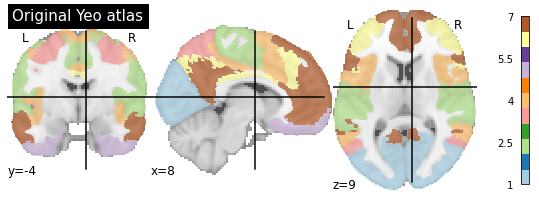

In [46]:
yeo = datasets.fetch_atlas_yeo_2011()['thick_7']

plotting.plot_roi(yeo, title='Original Yeo atlas',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

(256, 256, 256, 1) (256, 256, 256, 1)
(array([0, 6]), array([16621877,   155339]))
(array([0, 7]), array([16536238,   240978]))


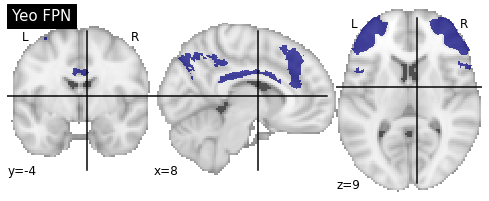

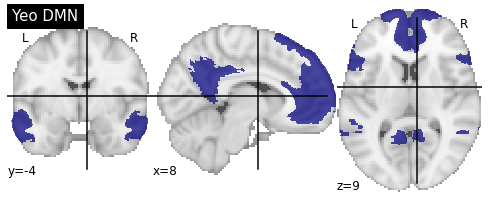

In [182]:
yeo_np = image.get_data(yeo).astype(np.int)
fpn = np.where(yeo_np == 6, yeo_np, 0)
dmn = np.where(yeo_np == 7, yeo_np, 0)
print(fpn.shape, dmn.shape)
print(np.unique(fpn, return_counts=True))
print(np.unique(dmn, return_counts=True))

yeo_fpn = image.new_img_like(yeo, fpn)
yeo_dmn = image.new_img_like(yeo, dmn)

plotting.plot_roi(yeo_fpn, title='Yeo FPN', cut_coords=(8, -4, 9))
plotting.plot_roi(yeo_dmn, title='Yeo DMN', cut_coords=(8, -4, 9))

In [200]:
# Combine both networks and calculate new regions for each network
# based on adjacent voxels. In other words, it finds islands of regions
# that are disconnected (aka not adjacent).
fpn_dmn = fpn + dmn
yeo_fpn_dmn = image.new_img_like(yeo, fpn_dmn)
subregions, subregion_labels = connected_label_regions(
    yeo_fpn_dmn, min_size=500, labels=["FPN", "DMN"])
unique, counts = np.unique(subregion_labels, return_counts=True)

# Rename labels to be more informative
current_subregion = subregion_labels[0]
current_counter = 1
for index, subregion in enumerate(subregion_labels):
    if subregion != current_subregion:
        current_counter = 1
        current_subregion = subregion
        
    subregion_labels[index] = f"{subregion}_{current_counter}"
    current_counter += 1

print("Original networks:", unique)
print("Num new regions per network:", counts)
print("Num new regions:", len(subregion_labels))
# print(subregion_labels)

Original networks: ['DMN' 'FPN']
Num new regions per network: [ 8 11]
Num new regions: 19


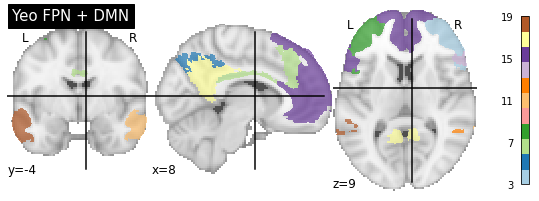

In [205]:
plotting.plot_roi(subregions, title='Yeo FPN + DMN',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



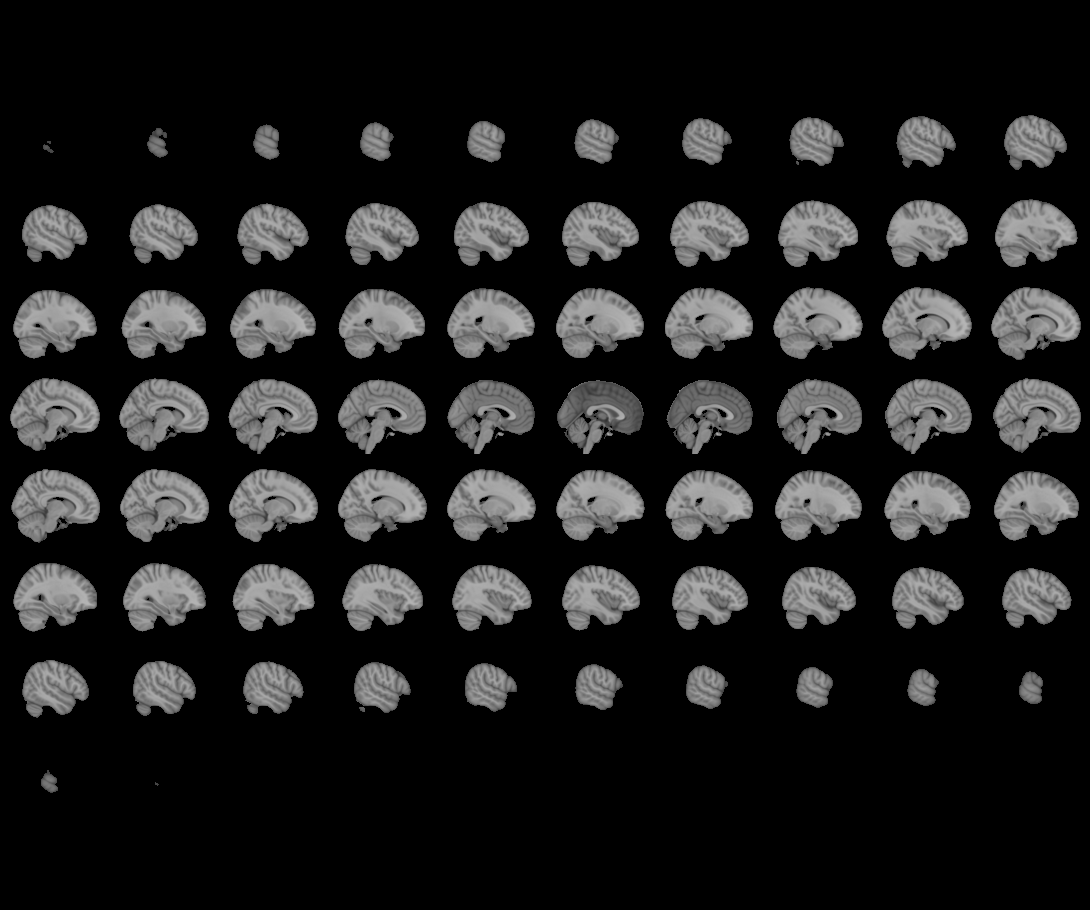
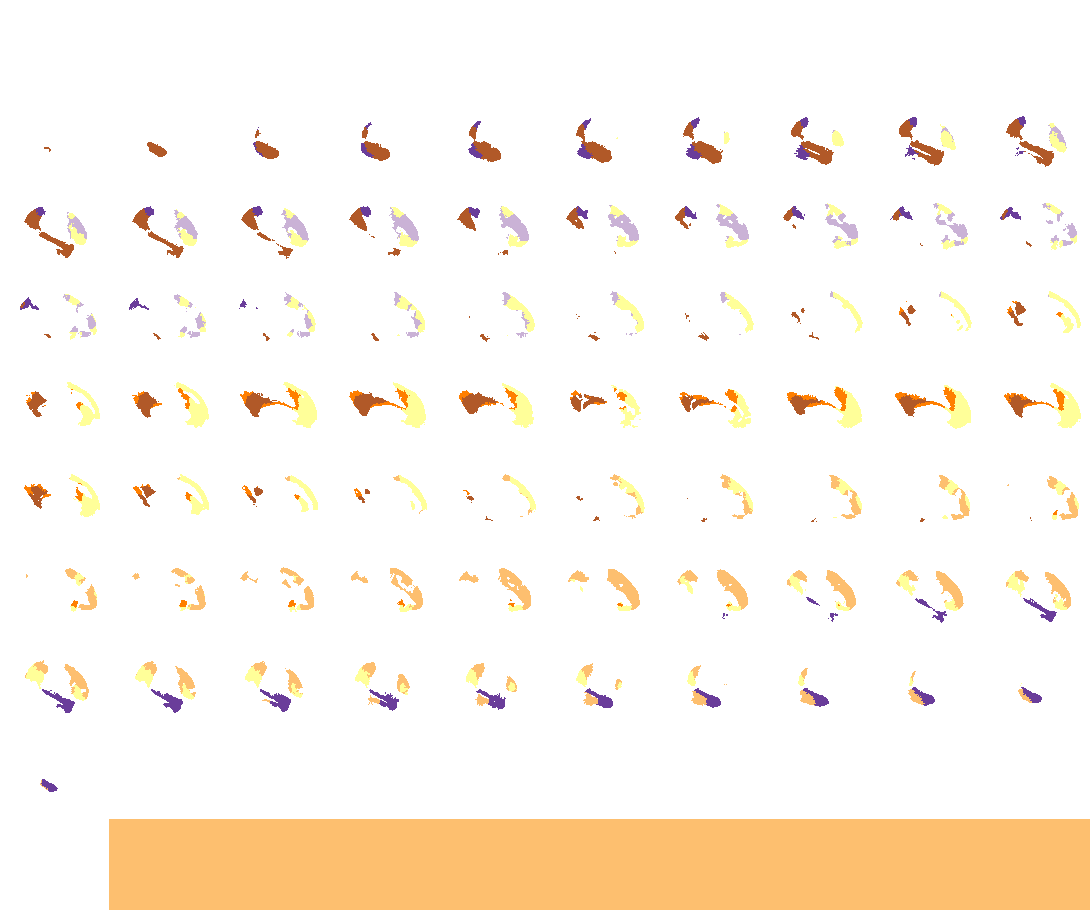

In [204]:
plotting.view_img(subregions, title='Yeo FPN + DMN', 
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

In [207]:
# Convert the subregions into coordinates using the region's center
subregion_coords = plotting.find_parcellation_cut_coords(subregions)
print(subregion_coords.shape)

(19, 3)


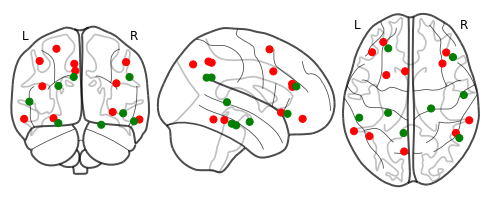

In [208]:
subregion_label_colors = []
for label in subregion_labels:
    if label.startswith('FPN'):
        subregion_label_colors.append('red')
    else:
        subregion_label_colors.append('green')

plotting.plot_connectome(
    np.zeros((19, 19)), subregion_coords, subregion_label_colors)
plotting.view_markers(
    subregion_coords, title='', marker_color=yeo_labels, marker_size=3)

In [244]:
scratch_dir = "/home/bpho/Documents/MSc_Research-Project/scratch_data"
np.save(f"{scratch_dir}/subregion_coords.npy", subregion_coords)
np.save(f"{scratch_dir}/subregion_labels.npy", subregion_labels)

## Generate subregion FC

In [214]:
aa_folder = 'BioBank_Analysis_All/'
saveresids_folder = 'aamod_firstlevel_modelestimate_saveresids_00001/'
python_fc_folder = 'python_yeo_fc'

In [210]:
spheres_masker = NiftiSpheresMasker(
    seeds=subregion_coords, smoothing_fwhm=6, radius=5., standardize=True)

def generate_yeo_fc(file):
    time_series = spheres_masker.fit_transform(file)
    
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    
    return correlation_matrix

In [247]:
def visualize_corr_matrix(corr_matrix):
    np.fill_diagonal(corr_matrix, 0)
    plotting.plot_matrix(corr_matrix, vmin=-1., vmax=1., colorbar=True, figure=(10, 10),
                     title='Yeo correlation matrix', labels=subregion_labels)
    plotting.plot_connectome(corr_matrix, subregion_coords, title='Yeo correlation graph',
                         edge_threshold='80%', node_size=20, colorbar=True)

Processing age: 7
  Processing subject: sub-NDARYA807PVN
    Time elapsed: 22.766295909881592


/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:31: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).height


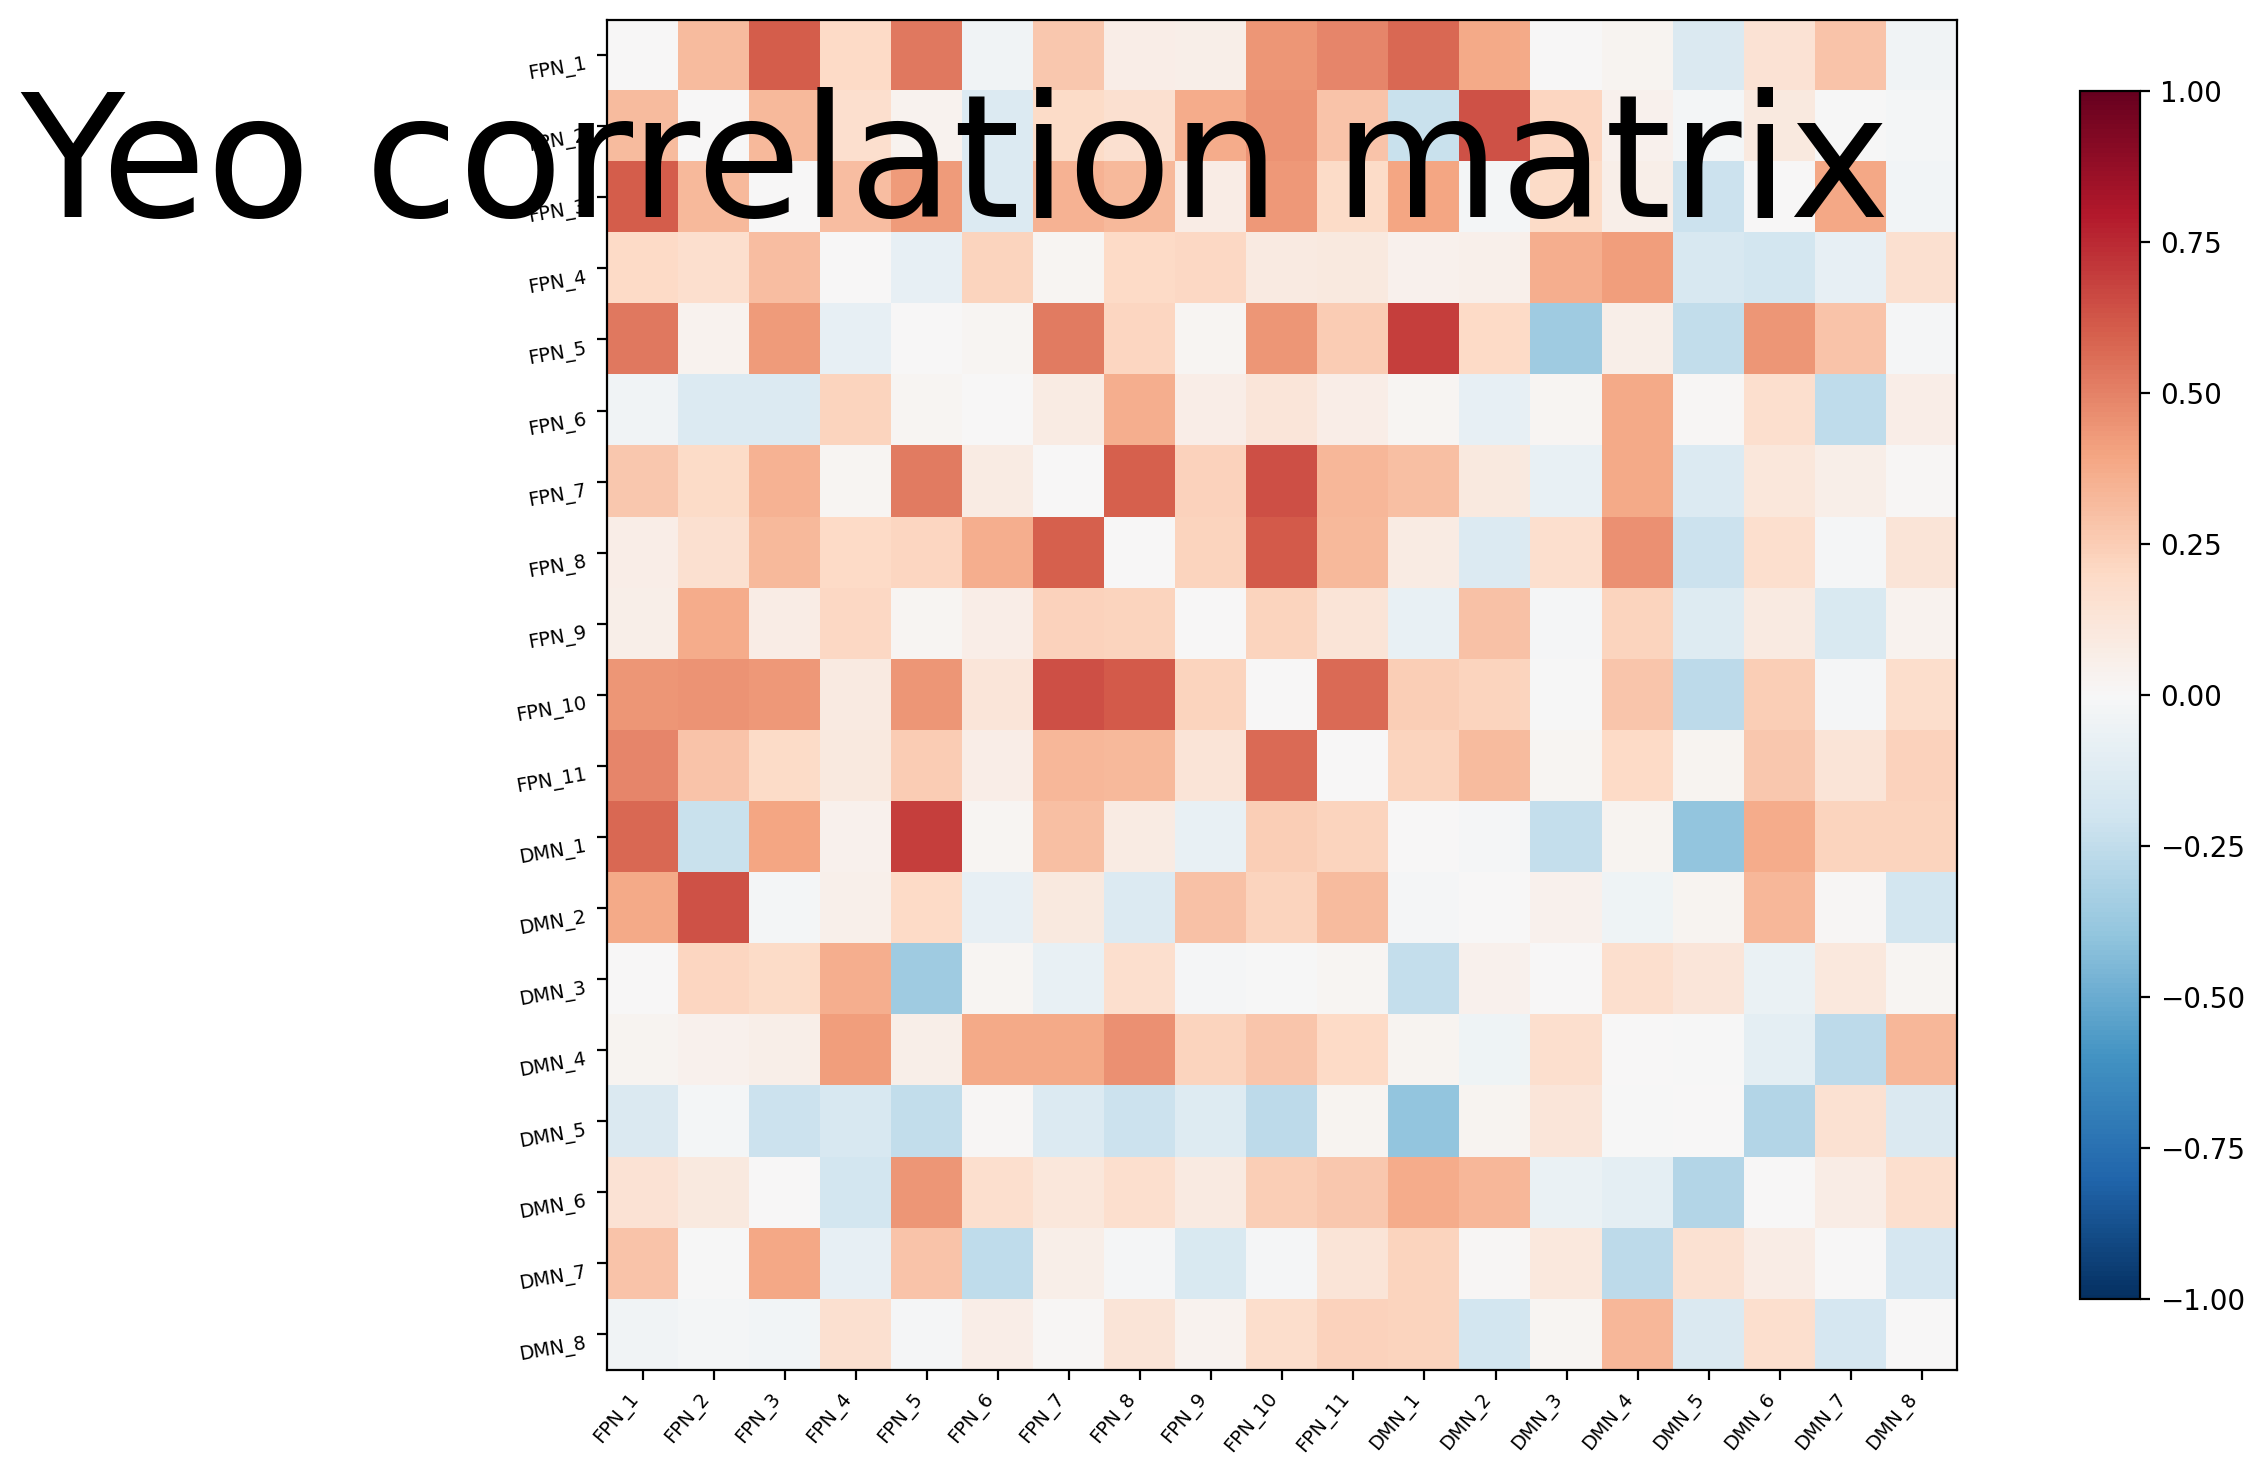

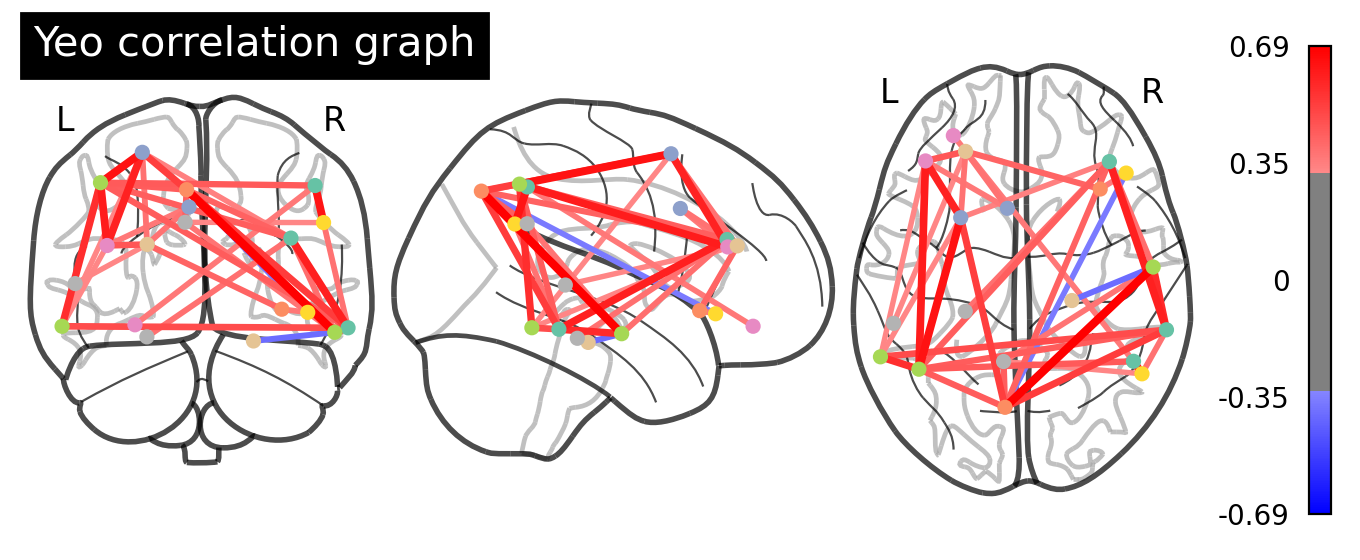

In [248]:
for age in range(7, 8):
    print("Processing age:", age)
    age_dir = f'/imaging3/owenlab/wilson/MovieData/Release7/Age{age}'

    input_path = join(age_dir, aa_folder, saveresids_folder)
    output_path = join(age_dir, aa_folder, python_fc_folder)

    # Grab all subjects
    subjects = [folder for folder in listdir(input_path) if folder.startswith("sub-")]

    for subject in subjects[0:1]:
        print("  Processing subject:", subject)
        start_time = time.time()
        subject_input_path = join(input_path, subject)
        subject_output_path = join(output_path, subject)

        # Check if we've already generated the FC for this subject
        if exists(subject_output_path):
            print("    Skipping subject due to already generated FC.")
            continue

        subject_niftis = [join(subject_input_path, f) for f in listdir(subject_input_path) 
                          if isfile(join(subject_input_path, f)) and f.startswith('ResI')]

        if len(subject_niftis) != 745:
            print("    Incomplete subject niftis:", len(subject_niftis))
            continue

        subject_concat_image = image.concat_imgs(subject_niftis)
        subject_corr_matrix = generate_yeo_fc(subject_concat_image)

#         makedirs(subject_output_path)
#         subject_corr_filename = join(subject_output_path, 'yeo_fc.npy')
#         np.save(subject_corr_filename, subject_corr_matrix)
        print("    Time elapsed:", time.time() - start_time)
        visualize_corr_matrix(subject_corr_matrix)

## Powers Atlas (UNUSED)
Unused due to inability to convert from power coordinates to Yeo MNI space.

In [66]:
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

[ 57 143 101]
[-71  15 -27]
(155339, 3)


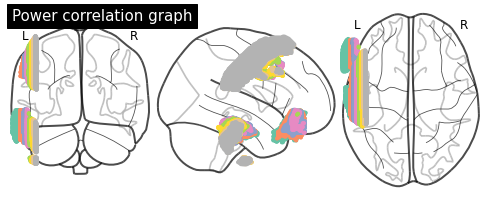

In [128]:
fpn = np.where(yeo_np == 6)
coords = np.vstack((fpn[0], fpn[1], fpn[2])).T
print(coords[0])
coords -= 128
print(coords[0])
print(coords.shape)
plotting.plot_connectome(np.zeros((30000, 30000)), coords[0:30000], title='Power correlation graph',
                         node_size=10)